# Weekly Covid Charts - Regional Groups

Author: Brian L. Fuller
Date Begun: 2020-10-16

In [37]:
import numpy as np
import pandas as pd

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as mplt
import matplotlib.dates as mdates

import bqplot
from bqplot import pyplot as plt


## Read the virus data

The virus data comes from a NY Times github repo. it's located at:

https://github.com/nytimes/covid-19-data

with article at:

https://www.nytimes.com/article/coronavirus-county-data-us.html

The data is pulled from the NYTimes github repo and should be located at the same level as this repo to be properly accessed. User must pull that repo in order to utilize updated numbers in this notebook.


In [38]:
# paths

rootpath = Path('..')

datapath = rootpath / 'data'

path_covid_data_us_counties = rootpath / '..' / 'covid-19-data' / 'us-counties.csv'

### Update this line
county_data_path = path_covid_data_us_counties

df_covid_data_us_counties = pd.read_csv(county_data_path, parse_dates=True)

# put fips=36061 as fips code for NYC
df_covid_data_us_counties.loc[df_covid_data_us_counties.county == "New York City", 'fips'] = 36061

# for now, get rid of null fips
df_covid = df_covid_data_us_counties[df_covid_data_us_counties.fips.notna()]

# convert the fips column to an int
df_covid['fips'] = df_covid['fips'].astype(int)

# convert the date column to a date-time
df_covid['date'] = pd.to_datetime(df_covid['date'])

In [94]:
# Helper Functions - entity access

def fips_for_group(data, group="DC Metro"):
    fips_list = []
    for fip in data[data['group']==group]['fips']:
        for fi in fip:
            fips_list.append(fi)
    return fips_list

def fips_for_state(data, state='VA'):
    fips_list = []
    for fip in data[data['state'] == state]['fips']:
        for fi in fip:
            fips_list.append(fi)
    return fips_list

def fips_for_county(data, county='Fairfax'):
    fips_list = []
    for fip in data[data['county'] == county]['fips']:
        for fi in fip:
            fips_list.append(fi)
    return fips_list

def frame_from_group(data_covid, data_groups, group="DC Metro"):
    fipslist = fips_for_group(data_groups, group)
    
    # filter the frame
    df = data_covid[data_covid.fips.isin(fipslist)]
    
    # get group population
    pop2020 = sum(data_groups[data_groups['group'] == group]['pop'])
    
    # derive new columns
    df = df.groupby(['date'])[['cases', 'deaths']].agg('sum').diff().reset_index()
    
    df['cases_7d'] = df.cases.rolling(7).mean().shift(-3)
    df['cases_100k'] = df['cases'] / pop2020 * 100000
    df['cases_7d_100k'] = df['cases_7d'] / pop2020 * 100000
    
    return df

def mpl_plot_from_group(df_covid, df_entity, group="DC Metro", ymax=80):
    df = frame_from_group(df_covid, df_entity, group)
    fig = mplt.figure(figsize=(14, 10))
    sns.lineplot(x="date",
                 y="cases_100k",
                 label="Daily",
                 data=df,
                 ci=None,
                 alpha=0.4)

    plot_ =  sns.lineplot(x="date",
                          y="cases_7d_100k",
                          label="7-Day Average",
                          data=df)
    fig.canvas.draw()
    mplt.legend()
    mplt.xlabel("Date", size=14)
    mplt.ylabel("Daily New Cases per 100,000 population", size=14)
    mplt.ylim(0, ymax)

    new_ticks = [i.get_text() for i in plot_.get_xticklabels()]
    mplt.xticks(range(0, len(new_ticks), 3), new_ticks[::3], 
               rotation=60, 
               fontweight='light', 
               fontsize="x-small");
    return

def mpl_plot_from_group_d(df_covid, df_entity, group="DC Metro", ymax=80):
    """Modify for x-axis as dates"""

    df = frame_from_group(df_covid, df_entity, group)

    mplt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    mplt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    mplt.plot(df["date"], 
              df["cases_100k"], 
              'bo',
              label="Cases/100K",
              markersize=2,
              alpha=.6)

    mplt.plot(df["date"], 
              df["cases_7d_100k"], 
              'r',
              label="7-Day Ave Cases/100K")

    mplt.gcf().autofmt_xdate()
    fig = mplt.gcf()
    fig.set_size_inches(14,10)
    mplt.ylim(0,ymax)
    mplt.legend()
    mplt.xlabel("Date", size=14)
    mplt.ylabel("Daily New Cases per 100,000 Population", size=14)
    return

## Regions

- DC Metro Area
- Tampa Metro Area
- Others?

### DC Metro - Virginia Counties:

- Culpeper county, va (51047) | 51859
- Fauquier county, va (51061) | 70675
- Spotsylvania county, va(51177) | 134238
- Stafford county, va (51179) | 149960
- Prince William county, va (51153) | 468011
- Fairfax county, va (51059)| 1150800
- Loudoun county, va (51107)| 406850
- Arlington county, va (51013) | 237521

### DC Metro - Independent Virginia Cities:

- City of Fredericksburg, VA (51630) | 29144
- City of Manassas, VA (51683) | 41641
- City of Fairfax, VA (51600) | 24574
- City of Falls Church, VA (51610) | 14772
- City of Alexandria, VA (51510) | 160530

### DC Metro - Federal District:

- District of Columbia, DC (11000, 11001, 11000) | 702455

### DC Metro - Maryland Counties:

- Charles county, md (24017) | 161503
- Prince Georges county, md (24033) | 909308
- Montgomery county, md (24031) | 1052570
- Howard county, md (24027) | 323196
- Anne Arundel county, md (fips 24003) | 576031
- Frederick county, md (24021) | 255648

https://worldpopulationreview.com/us-counties/states/va
https://worldpopulationreview.com/us-counties/states/dc
https://worldpopulationreview.com/us-counties/states/md


total pop (2020) = 6,921,286

### Tampa Metro - Florida Counties:

- Hillsborough County, FL (12057), pop = 1,436,890
- Pinellas (12103), pop = 975,280
- Pasco (12101), pop = 539,630

total pop = 2,951,800 (2020)

population from https://worldpopulationreview.com/us-counties/states/fl

In [40]:
# entity setup
culpeper = {'name': "Culpeper County, VA",          'pop':   51859, 'fips': [51047], 'state': 'VA', 'county': "Culpeper",       'group': "DC Metro"}
fauquier = {'name': "Fauquier County, VA",          'pop':   70675, 'fips': [51061], 'state': 'VA', 'county': "Fauquier",       'group': "DC Metro"}
spotsylvania = {'name': "Spotsylvania County, VA",  'pop':  134238, 'fips': [51177], 'state': 'VA', 'county': "Spotsylvania",   'group': "DC Metro"}
stafford = {'name': "Stafford County, VA",          'pop':  149960, 'fips': [51179], 'state': 'VA', 'county': "Stafford",       'group': "DC Metro"}
pr_william = {'name': "Prince William Country, VA", 'pop':  468011, 'fips': [51153], 'state': 'VA', 'county': "Prince William", 'group': "DC Metro"}
fairfax = {'name': "Fairfax County, VA",            'pop': 1150800, 'fips': [51059], 'state': 'VA', 'county': "Fairfax",        'group': "DC Metro"}
loudoun = {'name': "Loudoun County, VA",            'pop':  406850, 'fips': [51107], 'state': 'VA', 'county': "Loudoun",        'group': "DC Metro"}
arlington = {'name': "Arlington County, VA",        'pop':  237521, 'fips': [51013], 'state': 'VA', 'county': "Arlington",      'group': "DC Metro"}

fredericksburg = {'name': "Fredericksburg, VA",     'pop':  29144, 'fips': [51630], 'state': 'VA', 'county': "Spotsylvania",   'group': "DC Metro"}
manassas = {'name': "Manassas, VA",                 'pop':  41641, 'fips': [51683], 'state': 'VA', 'county': "Prince William", 'group': "DC Metro"}
fairfax_city = {'name': "Fairfax City, VA",         'pop':  24574, 'fips': [51600], 'state': 'VA', 'county': "Fairfax",        'group': "DC Metro"}
falls_church = {'name': "City of Falls Church, VA", 'pop':  14772, 'fips': [51610], 'state': 'VA', 'county': "Fairfax",        'group': "DC Metro"}
alexandria = {'name': "City of Alexandria, VA",     'pop': 160530, 'fips': [51510], 'state': 'VA', 'county': "Fairfax",        'group': "DC Metro"}

dc = {'name': "District of Columbia", 'pop': 702455, 'fips': [11000, 11001], 'state': 'DC', 'county': "DC", 'group': "DC Metro"}

charles = {'name': "Charles County, MD",           'pop':  161503, 'fips': [24017], 'state': 'MD', 'county': "Charles",       'group': "DC Metro"}
pr_george = {'name': "Prince Georges County, MD",  'pop':  909308, 'fips': [24033], 'state': 'MD', 'county': "Prince George", 'group': "DC Metro"}
montgomery = {'name': "Montgomery County, MD",     'pop': 1052570, 'fips': [24031], 'state': 'MD', 'county': "Montgomery",    'group': "DC Metro"}
howard = {'name': "Howard County, MD",             'pop':  323196, 'fips': [24027], 'state': 'MD', 'county': "Howard",        'group': "DC Metro"}
anne_arundel = {'name': "Anne Arundel County, MD", 'pop':  576031, 'fips': [24003], 'state': 'MD', 'county': "Anne Arundel",  'group': "DC Metro"}
frederick = {'name': "Frederick County, MD",       'pop':  255648, 'fips': [24021], 'state': 'MD', 'county': "Frederick",     'group': "DC Metro"}

hillsborough = {'name': "Hillsborough County, FL", 'pop':  1436890, 'fips': [12057], 'state': 'FL', 'county': "Hillsborough", 'group': "Tampa Bay-Area"}
pinellas = {'name': "Pinellas County, FL",         'pop':   975280, 'fips': [12103], 'state': 'FL', 'county': "Pinellas",     'group': "Tampa Bay-Area"}
pasco = {'name': "Pasco County, FL",               'pop':   539630, 'fips': [12101], 'state': 'FL', 'county': "Pasco",        'group': "Tampa Bay-Area"}


df_entity = pd.DataFrame([culpeper, fauquier, spotsylvania, stafford, pr_william, fairfax,
                          loudoun, arlington, fredericksburg, manassas, fairfax_city,
                          falls_church, alexandria, dc, charles, pr_george, montgomery, howard,
                          anne_arundel, frederick, hillsborough, pinellas, pasco])

In [41]:
# check the regional population
assert sum(df_entity[df_entity['group']=='DC Metro']['pop']) == 6921286

In [42]:
frame_from_group(df_covid, df_entity, "DC Metro").tail(20)

,date,cases,deaths,cases_7d,cases_100k,cases_7d_100k
211,2020-10-02,688.0,6.0,564.714286,9.940349,8.159095
212,2020-10-03,519.0,0.0,547.714286,7.498606,7.913476
213,2020-10-04,739.0,4.0,545.142857,10.677207,7.876323
214,2020-10-05,494.0,2.0,607.857143,7.137402,8.782431
215,2020-10-06,463.0,4.0,615.857143,6.689508,8.898016
216,2020-10-07,415.0,7.0,634.142857,5.995996,9.162211
217,2020-10-08,937.0,14.0,630.714286,13.537947,9.112675
218,2020-10-09,744.0,9.0,655.142857,10.749447,9.465623
219,2020-10-10,647.0,4.0,686.571429,9.347974,9.919709
220,2020-10-11,715.0,7.0,707.285714,10.330450,10.218993


In [43]:
frame_from_group(df_covid, df_entity, "DC Metro").head(20)

,date,cases,deaths,cases_7d,cases_100k,cases_7d_100k
0,2020-03-05,NaN,NaN,NaN,NaN,NaN
1,2020-03-06,0.0,0.0,NaN,0.000000,NaN
2,2020-03-07,2.0,0.0,NaN,0.028896,NaN
3,2020-03-08,2.0,0.0,NaN,0.028896,NaN
4,2020-03-09,6.0,0.0,4.000000,0.086689,0.057793
5,2020-03-10,5.0,0.0,5.571429,0.072241,0.080497
6,2020-03-11,11.0,0.0,8.285714,0.158930,0.119714
7,2020-03-12,2.0,0.0,9.000000,0.028896,0.130034
8,2020-03-13,11.0,0.0,10.000000,0.158930,0.144482
9,2020-03-14,21.0,0.0,13.857143,0.303412,0.200211


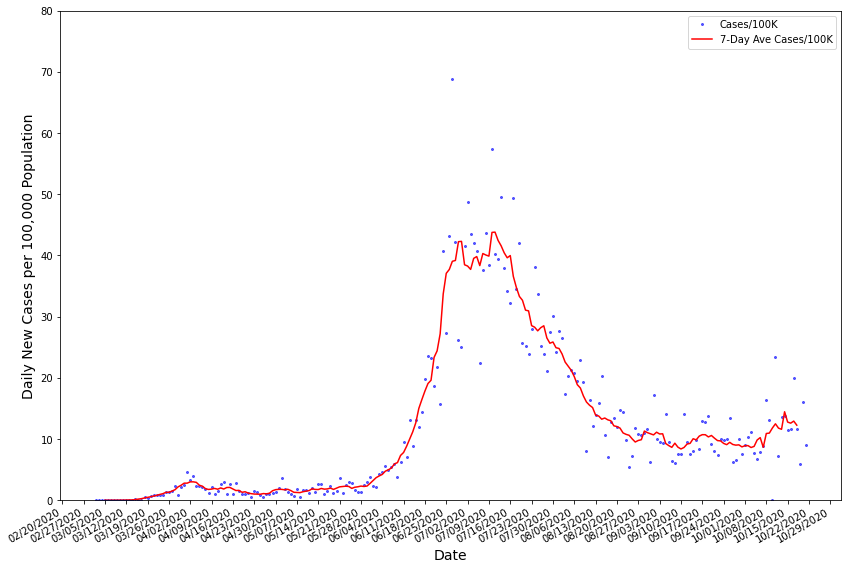

In [95]:
mpl_plot_from_group_d(df_covid, df_entity, "Tampa Bay-Area")

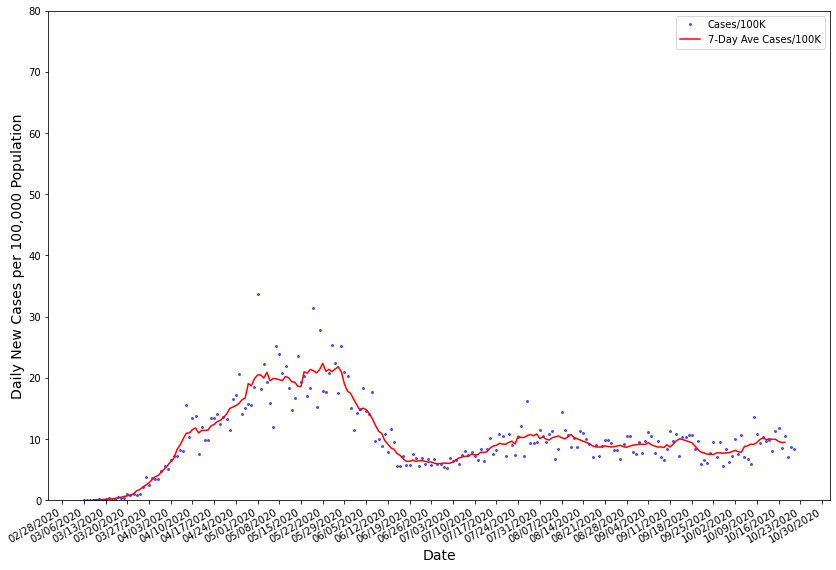

In [96]:
mpl_plot_from_group_d(df_covid, df_entity, "DC Metro")

In [ ]:
    mytitle = "DC Metro"
    group = "DC Metro"


    df = frame_from_group(df_covid, df_entity, group)
    df['cases_7d_100k'].tail(20)

In [ ]:
    xs = bqplot.DateScale()
    ys = bqplot.LinearScale()
    
    line = bqplot.Lines(x=df['date'],
                        y=df['cases'],
                        scales={'x': xs, 'y': ys})
    xax = bqplot.Axis(scale=xs)
    yax = bqplot.Axis(scale=ys, orientation='vertical')
    
    bqplot.Figure(marks=[line], axes=[xax, yax], title=mytitle, animate=True, enable_hover=True)
    # fig = plt.figure(title=mytitle)
    
    # line = plt.plot(x=df['date'].values, y=df['cases'].values)
    # plt.show()

In [ ]:
    fig = plt.figure(title=mytitle)
    
    line = plt.plot(x=df['date'].values, y=df['cases'].values)
    plt.show()

In [ ]:
df['date']

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df['date']